In [1]:
import pymysql.cursors
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as mticker
from datetime import datetime, timedelta
import numpy as np

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='root',
                             db='tv4e_new',
                             charset='latin1',
                             cursorclass=pymysql.cursors.DictCursor)
connection

In [2]:
query = "SELECT * FROM majordomo_users WHERE NOT id IN (99)"
df_users = pd.read_sql(query, connection)
df_users.mean_tv_daily_usage = df_users.mean_tv_daily_usage.astype(float)
df_users

,id,name,gender,age,mean_tv_daily_usage,coordinates,city_id
0,1,Helena Letra,F,59,2.0,"40.450827, -8.506811",3
1,2,Cesar Castelao,M,68,3.0,"40.433520,-8.461226",3
2,3,José Martins,M,71,6.0,"40.444435,-8.436251",3
3,4,Ian Arbuckle,M,66,1.0,"40.6023542,-8.5682549",5
4,5,Francisco Silva,M,85,4.0,"40.629803,-8.608807",5
5,6,Hernani,M,86,7.0,"40.6370521,-8.6981238",5
6,7,Maria Carmo,F,78,6.0,"40.3391064,-8.4286726",3
7,8,Rosa Ferreira (Vizinhos Rita),F,80,4.0,"40.840397,-8.477349",12
8,9,Helena Gala,F,70,1.0,"40.450827, -8.506811",3
9,10,Teresa Rei,F,66,2.5,"40.453439, -8.462946",3


In [3]:
query = "SELECT * FROM majordomo_userlogs l WHERE NOT user_id IN (99)"
df_logs = pd.read_sql(query, connection)

print(df_logs.shape[0])
df_logs.head()


23370


,user_id,video_id,log_event,log_id,on_state,log_date
0,4,NaN,None,102071,1.0,2017-12-04 08:55:23
1,4,NaN,None,102072,1.0,2017-12-04 08:55:23
2,4,NaN,None,102073,1.0,2017-12-04 08:55:33
3,4,NaN,None,102074,0.0,2017-12-04 08:56:57
4,4,NaN,None,102075,0.0,2017-12-04 08:56:57


In [4]:
query = "SELECT r.*, u.name, v.video_duration FROM majordomo_ratings_all r, majordomo_videos_all v, majordomo_users u WHERE r.user_id = u.id AND r.video_id = v.video_id AND NOT (r.video_watched_type = 'forced' OR r.video_watched_type = 'mobile' OR r.user_id IN (99))"
df_ratings = pd.read_sql(query, connection)
columns={'video_watched_time': 'rating_implicit', 
         'rating_value': 'rating_explicit',
         'video_watched_type': 'watched_type',
         'rating_date_creation': 'date_creation'
        }
df_ratings.rename(columns=columns, inplace=True)
df_ratings.rating_implicit = df_ratings.rating_implicit/100

df_ratings.describe()

,user_id,video_id,rating_implicit,rating_explicit,video_duration
count,761.000000,761.000000,761.000000,384.000000,761.000000
mean,12.461235,5508.929041,0.930644,0.218750,144.294350
std,5.224576,448.810273,0.234841,0.554179,82.784375
min,1.000000,4459.000000,0.010000,-1.000000,19.000000
25%,8.000000,4944.000000,1.000000,0.000000,83.000000
50%,14.000000,5676.000000,1.000000,0.000000,136.000000
75%,16.000000,5800.000000,1.000000,1.000000,189.000000
max,21.000000,6357.000000,1.000000,1.000000,453.000000


In [5]:
# adjust ratings' watched types 
def f(row):
    if 'SEEN VIDEO LIBRARY' in                                                                                     \
                df_logs[(df_logs.user_id == row.user_id) & (df_logs.video_id == row.video_id)].log_event.unique():
        return 'library'
    else:
        return row.watched_type

df_ratings['watched_type'] = df_ratings.apply(lambda row: f(row), axis=1)
df_ratings.head()

,user_id,user_name,video_id,rating_implicit,date_creation,rating_explicit,watched_type,name,video_duration
0,7,Maria Carmo,4622,1.0,2017-12-11 08:30:01,-1.0,library,Maria Carmo,126
1,2,Cesar Castelao,4881,1.0,2017-12-14 22:00:01,0.0,injected,Cesar Castelao,159
2,7,Maria Carmo,4881,1.0,2017-12-15 22:30:01,1.0,injected,Maria Carmo,159
3,2,Cesar Castelao,4882,1.0,2017-12-14 21:30:01,NaN,injected,Cesar Castelao,236
4,7,Maria Carmo,4882,1.0,2017-12-14 21:30:01,NaN,injected,Maria Carmo,236


In [6]:
# calculating tv usage with user logs
def get_mean_tv_daily_usage(user_id):
    df = df_logs[df_logs.user_id == user_id]
    df.sort_values('log_date', inplace=True)
    df['log_date_anterior'] = df.log_date.shift(+1)
    df['on_state_anterior'] = df.on_state.shift(+1)
    df['diff_date'] = df.log_date - df.log_date_anterior
    
    seconds_counter = 0
    last_date = datetime(2000,1,1)
    counting = False
    for index,row in df.iterrows():
        if (row.log_event == 'SLEEP_2'):
            continue
        elif (
            (row.diff_date.total_seconds() <= 180) or
            (
                (row.diff_date.total_seconds() <= 1800) and (row.on_state_anterior == 1 or pd.isnull(row.on_state_anterior))
            )
           ):
            seconds_counter += row.diff_date.total_seconds()

    hour_count = seconds_counter/3600
    day_count = len(df.log_date.dt.day.unique())

    return (hour_count/day_count)


df_users['mean_tv_daily_usage_system'] = df_users.apply(lambda row: get_mean_tv_daily_usage(row.id), axis=1)
df_users

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,id,name,gender,age,mean_tv_daily_usage,coordinates,city_id,mean_tv_daily_usage_system
0,1,Helena Letra,F,59,2.0,"40.450827, -8.506811",3,1.127153
1,2,Cesar Castelao,M,68,3.0,"40.433520,-8.461226",3,2.635437
2,3,José Martins,M,71,6.0,"40.444435,-8.436251",3,6.101389
3,4,Ian Arbuckle,M,66,1.0,"40.6023542,-8.5682549",5,2.077778
4,5,Francisco Silva,M,85,4.0,"40.629803,-8.608807",5,2.696131
5,6,Hernani,M,86,7.0,"40.6370521,-8.6981238",5,1.125972
6,7,Maria Carmo,F,78,6.0,"40.3391064,-8.4286726",3,3.337222
7,8,Rosa Ferreira (Vizinhos Rita),F,80,4.0,"40.840397,-8.477349",12,3.230884
8,9,Helena Gala,F,70,1.0,"40.450827, -8.506811",3,1.984259
9,10,Teresa Rei,F,66,2.5,"40.453439, -8.462946",3,1.842562


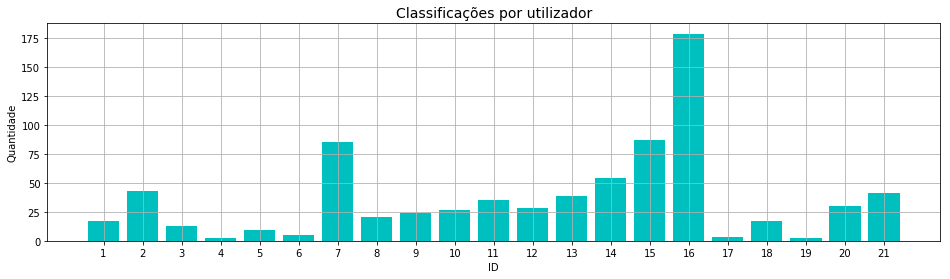

Número de classificações: 761
ID dos utilizadores: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21']
Número de utilizadores: 21
Média de vídeos vistos por utilizador: 36


In [7]:
# Grouping ratings by user
df_ratings_by_user = df_ratings.groupby(['user_id']).size().reset_index(name='counts')
id = df_ratings_by_user.user_id.unique().astype(str)
plt.clf()
fig = plt.figure(figsize=(16,4))

plt.title('Classificações por utilizador', fontsize=14)
plt.bar(range(len(id)), df_ratings_by_user.counts, color='c', width=0.8)
plt.ylabel('Quantidade')
plt.xlabel('ID')

plt.xticks(range(len(id)),id)

plt.grid(True)
plt.show()

number_of_ratings = df_ratings.shape[0]
number_of_users = len(id)
print("Número de classificações: {}".format(number_of_ratings))
print("ID dos utilizadores: {}".format(id))
print("Número de utilizadores: {}".format(number_of_users))
print("Média de vídeos vistos por utilizador: {0:.0f}".format(number_of_ratings/number_of_users))

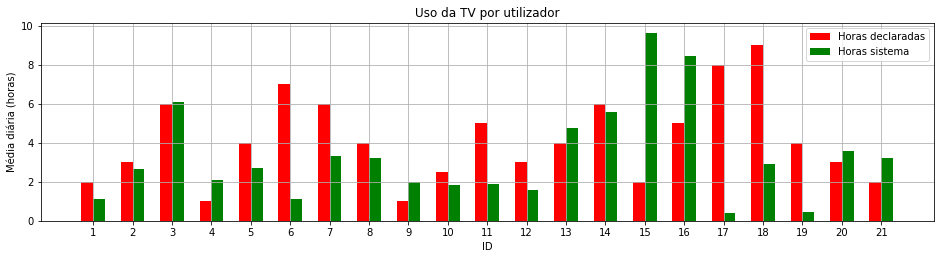

,id,mean_tv_daily_usage,city_id,mean_tv_daily_usage_system
count,21.000000,21.000000,21.000000,21.000000
mean,11.000000,4.166667,5.809524,3.272375
std,6.204837,2.221111,4.534524,2.440721
min,1.000000,1.000000,3.000000,0.413111
25%,6.000000,2.500000,3.000000,1.842562
50%,11.000000,4.000000,3.000000,2.696131
75%,16.000000,6.000000,5.000000,3.595315
max,21.000000,9.000000,14.000000,9.651212


In [8]:
# TV daily usage 
df_ratings_by_user = df_ratings.groupby(['user_id']).size().reset_index(name='counts')
id = df_ratings_by_user.user_id.unique().astype(str)
plt.clf()
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((2,1),(0,0))
plt.title('Uso da TV por utilizador')

ax1.bar(df_users.id-0.15, df_users.mean_tv_daily_usage,        color='r', label='Horas declaradas', width=0.30)
ax1.bar(df_users.id+0.15, df_users.mean_tv_daily_usage_system, color='g', label='Horas sistema', width=0.30)
ax1.legend(loc='best')

ax1.set_ylabel('Média diária (horas)')
ax1.set_xlabel('ID')
ax1.set_xticklabels(df_users.id)
ax1.set_xticks(df_users.id)

ax1.grid(True)
plt.show()


df_users.describe()

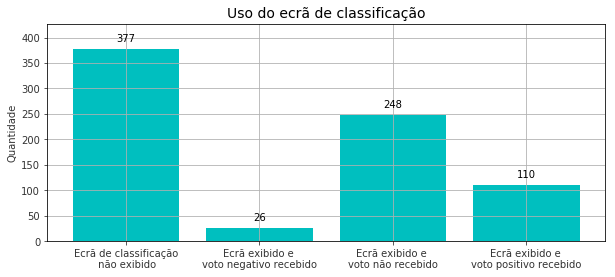

In [9]:
# Checking ratings distribution
df_ratings_distribution = df_ratings.fillna(-2) # using -2 to represent the scenario where no rating screen was shown
df_ratings_distribution = df_ratings_distribution.groupby(['rating_explicit']).size().reset_index(name='counts')


plt.clf()
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot2grid((1,1), (0,0))
ax1.set_title('Uso do ecrã de classificação', fontsize=14)

ax1.bar(range(len(df_ratings_distribution.rating_explicit)), df_ratings_distribution.counts, color='c', width=0.8)
ax1.set_ylabel('Quantidade', color='#333333')
ax1.set_ylim(0, df_ratings_distribution.counts.max()+50)

labels = ['Ecrã de classificação\n não exibido',
          'Ecrã exibido e \nvoto negativo recebido', 
          'Ecrã exibido e \nvoto não recebido',
          'Ecrã exibido e \nvoto positivo recebido']

for i in range(len(df_ratings_distribution.rating_explicit)):
    ax1.annotate(str(df_ratings_distribution.counts[i]), (i, df_ratings_distribution.counts[i]),
                 xytext = (i, df_ratings_distribution.counts[i]+20), 
                 horizontalalignment='center', verticalalignment='center')

ax1.tick_params(axis='x', colors='#333333')
ax1.tick_params(axis='y', colors='#333333')
ax1.set_xticks(range(len(df_ratings_distribution.rating_explicit)))
ax1.set_xticklabels(labels)

ax1.grid(True)
plt.show()

In [10]:
        # Checking algoritmh precision

df_precision = df_ratings

positive_votes = df_precision[df_precision['rating_explicit'] ==  1].shape[0]
negative_votes = df_precision[df_precision['rating_explicit'] == -1].shape[0]
neutral_votes  = df_precision[df_precision['rating_explicit'] ==  0].shape[0]
all_votes = df_precision.shape[0]
not_show_votes = all_votes - neutral_votes - positive_votes - negative_votes

precision = positive_votes/(positive_votes+negative_votes)
print("Precisão do algoritmo: {0:.2f}%". format(precision*100))
print("Votos positivos: {0} {1:.2f}%". format(positive_votes, positive_votes/(all_votes)*100))
print("Votos negativos: {0}  {1:.2f}%". format(negative_votes, negative_votes/(all_votes)*100))
print("Votos não declarados: {0}  {1:.2f}%". format(neutral_votes, neutral_votes/(all_votes)*100))
print("Votos não solicitados: {0}  {1:.2f}%". format(not_show_votes, not_show_votes/(all_votes)*100))

Precisão do algoritmo: 80.88%
Votos positivos: 110 14.45%
Votos negativos: 26  3.42%
Votos não declarados: 248  32.59%
Votos não solicitados: 377  49.54%


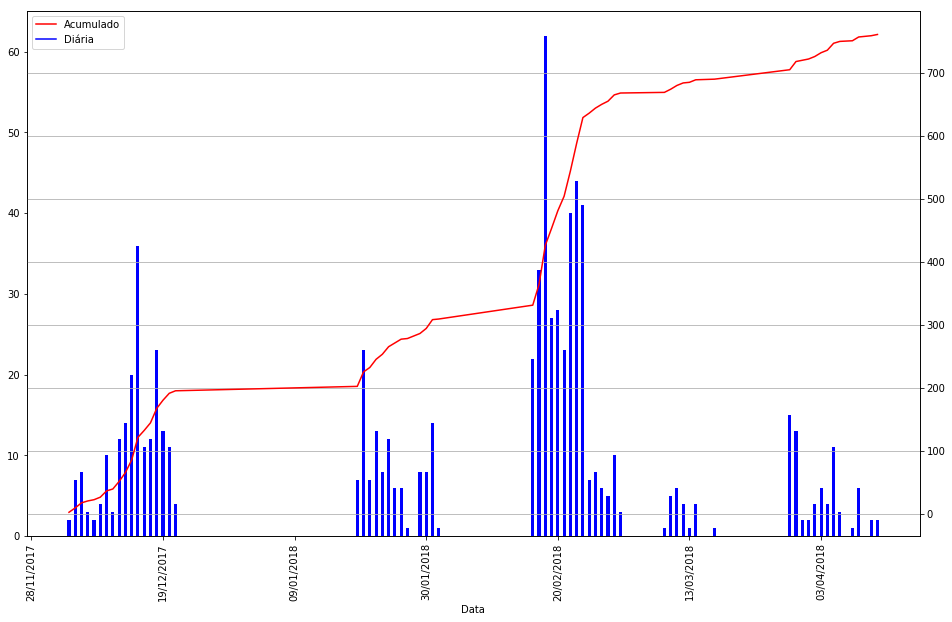

In [11]:
from collections import Counter
import datetime as dt
import matplotlib.dates as mdates

df_ratings['TimeStamp'] = pd.to_datetime(df_ratings['date_creation']).dt.strftime('%m/%d/%Y')
d = Counter(df_ratings['TimeStamp'])
df = pd.DataFrame(list(d.items()), columns=['Date', 'Count'])
df = df.set_index('Date').sort_index()
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

plt.clf()
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))
ax2 = ax1.twinx()

ax1.bar(df.index, df.Count, color='b', width=0.5)
ax2.plot(df.index, df.Count.cumsum(), color='r', label='Acumulado')
ax2.plot([], [], color='b', label='Diária')


ax1.set_xlabel('Data')

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d/%m/%Y"))

fig.subplots_adjust(bottom=0.15)
ax2.legend(loc='best')

plt.grid(True)
plt.show()


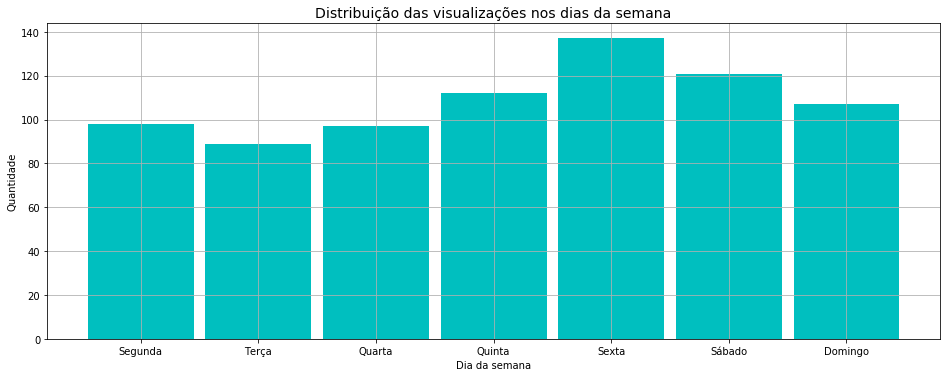

,weekday_name,count
weekday,,
0,Segunda,98
1,Terça,89
2,Quarta,97
3,Quinta,112
4,Sexta,137
5,Sábado,121
6,Domingo,107


In [12]:
from collections import Counter
import datetime as dt
import matplotlib.dates as mdates

weekdays_keys = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays_values = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
weekdays_dict = dict(zip(weekdays_keys, weekdays_values))

df_ratings['weekday_name'] = pd.to_datetime(df_ratings['date_creation']).dt.weekday_name
d = Counter(df_ratings['weekday_name'])

df = pd.DataFrame(list(d.items()), columns=['weekday_name', 'count'])
def f(row):
    return weekdays_keys.index(row['weekday_name'])
df['weekday'] = df.apply(f, axis=1)

df['weekday_name'].replace(weekdays_dict, inplace=True)
df = df.set_index('weekday').sort_index()

plt.clf()
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot2grid((1,1), (0,0))
plt.title('Distribuição das visualizações nos dias da semana', fontsize=14)

ax1.bar(df.index, df['count'], color='c', width=0.9)
ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Dia da semana')
ax1.set_xticklabels(weekdays_values)
ax1.set_xticks(range(len(weekdays_values)))

fig.subplots_adjust(bottom=0.15)
ax2.legend(loc='best')

plt.grid(True)
plt.show()
df

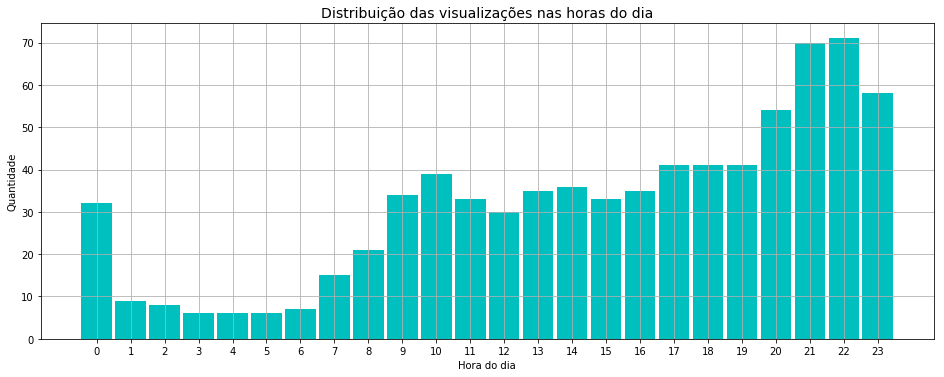

In [13]:
from collections import Counter
import datetime as dt

df_ratings['hour'] = pd.to_datetime(df_ratings['date_creation']).dt.hour
d = Counter(df_ratings['hour'])

df = pd.DataFrame(list(d.items()), columns=['hour', 'count'])

plt.clf()
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot2grid((1,1), (0,0))
plt.title('Distribuição das visualizações nas horas do dia', fontsize=14)

ax1.bar(df.index, df['count'], color='c', width=0.9)
ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Hora do dia')
ax1.set_xticks(range(len(df.hour)))
ax1.set_xticklabels(df.hour)
fig.subplots_adjust(bottom=0.15)

plt.grid(True)
plt.show()

In [14]:
# df_ratings
df = pd.DataFrame(df_ratings[['watched_type', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)
# df_corr = df_corr[df_corr.rating_explicit != 0]

injetados_positivos   = df[(df.rating_explicit == 1)     & (df.watched_type_injected == 1)].shape[0]
injetados_negativos   = df[(df.rating_explicit == -1)    & (df.watched_type_injected == 1)].shape[0]
injetados_neutros     = df[(df.rating_explicit == 0)     & (df.watched_type_injected == 1)].shape[0]
injetados_nulos       = df[pd.isnull(df.rating_explicit) & (df.watched_type_injected == 1)].shape[0]
injetados_total       = df[(df.watched_type_injected == 1)].shape[0]
notificados_positivos = df[(df.rating_explicit == 1)     & (df.watched_type_notified == 1)].shape[0]
notificados_negativos = df[(df.rating_explicit == -1)    & (df.watched_type_notified == 1)].shape[0]
notificados_neutros   = df[(df.rating_explicit == 0)     & (df.watched_type_notified == 1)].shape[0]
notificados_nulos     = df[pd.isnull(df.rating_explicit) & (df.watched_type_notified == 1)].shape[0]
notificados_total     = df[(df.watched_type_notified == 1)].shape[0]
listagem_positivos = df[(df.rating_explicit == 1)        & (df.watched_type_library == 1)].shape[0]
listagem_negativos = df[(df.rating_explicit == -1)       & (df.watched_type_library == 1)].shape[0]
listagem_neutros   = df[(df.rating_explicit == 0)        & (df.watched_type_library == 1)].shape[0]
listagem_nulos     = df[pd.isnull(df.rating_explicit)    & (df.watched_type_library == 1)].shape[0]
listagem_total     = df[(df.watched_type_library == 1)].shape[0]
print("injetados_positivos:   "+ str(injetados_positivos))
print("injetados_negativos:   "+ str(injetados_negativos))
print("injetados_neutros:     "+ str(injetados_neutros))
print("injetados_nulos:       "+ str(injetados_nulos))
print("injetados_total:       "+ str(injetados_total))
print("notificados_positivos: "+ str(notificados_positivos))
print("notificados_negativos: "+ str(notificados_negativos))
print("notificados_neutros:   "+ str(notificados_neutros))
print("notificados_nulos:     "+ str(notificados_nulos))
print("notificados_total:     "+ str(notificados_total))
print("listagem_positivos: "+ str(listagem_positivos))
print("listagem_negativos: "+ str(listagem_negativos))
print("listagem_neutros:   "+ str(listagem_neutros))
print("listagem_nulos:     "+ str(listagem_nulos))
print("listagem_total:     "+ str(listagem_total))

# df.dropna(inplace=True)
df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

# df_corr1 = df.corr()
# df_corr1 = df_corr1.drop(df_corr1.columns[:2], axis=1)
# df_corr1 = df_corr1.drop(df_corr1.index[2:], axis=0)
# df_corr1.round(2)
df.corr().round(2)

injetados_positivos:   55
injetados_negativos:   13
injetados_neutros:     212
injetados_nulos:       279
injetados_total:       559
notificados_positivos: 35
notificados_negativos: 9
notificados_neutros:   25
notificados_nulos:     60
notificados_total:     129
listagem_positivos: 20
listagem_negativos: 4
listagem_neutros:   11
listagem_nulos:     38
listagem_total:     73


,rating_explicit,rating_implicit,watched_type_injected,watched_type_library,watched_type_notified
rating_explicit,1.00,0.08,-0.00,0.03,-0.02
rating_implicit,0.08,1.00,0.17,0.14,-0.30
watched_type_injected,-0.00,0.17,1.00,-0.46,-0.69
watched_type_library,0.03,0.14,-0.46,1.00,-0.32
watched_type_notified,-0.02,-0.30,-0.69,-0.32,1.00


In [15]:
# df_ratings
df = pd.DataFrame(df_ratings[['date_creation', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)

df['weekday'] = pd.to_datetime(df_ratings['date_creation']).dt.weekday

df['weekend'] = df.apply(lambda row: row.weekday >= 5,axis=1)
df['workingday'] = df.apply(lambda row: row.weekday < 5,axis=1)

weekend_positivos    = df[(df.rating_explicit == 1)     & (df.weekend)].shape[0]
weekend_negativos    = df[(df.rating_explicit == -1)    & (df.weekend)].shape[0]
weekend_neutros      = df[(df.rating_explicit == 0)     & (df.weekend)].shape[0]
weekend_nulos        = df[pd.isnull(df.rating_explicit) & (df.weekend)].shape[0]
weekend_total        = df[(df.weekend)].shape[0]
workingday_positivos = df[(df.rating_explicit == 1)     & (df.workingday)].shape[0]
workingday_negativos = df[(df.rating_explicit == -1)    & (df.workingday)].shape[0]
workingday_neutros   = df[(df.rating_explicit == 0)     & (df.workingday)].shape[0]
workingday_nulos     = df[pd.isnull(df.rating_explicit) & (df.workingday)].shape[0]
workingday_total     = df[(df.workingday)].shape[0]

print("workingday_positivos: "+ str(workingday_positivos))
print("workingday_negativos: "+ str(workingday_negativos))
print("workingday_neutros:   "+ str(workingday_neutros))
print("workingday_nulos:     "+ str(workingday_nulos))
print("workingday_total:     "+ str(workingday_total))
print("weekend_positivos:    "+ str(weekend_positivos))
print("weekend_negativos:    "+ str(weekend_negativos))
print("weekend_neutros:      "+ str(weekend_neutros))
print("weekend_nulos:        "+ str(weekend_nulos))
print("weekend_total:        "+ str(weekend_total))

# df.dropna(inplace=True)
df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

df_corr2 = df.corr()
df_corr2 = df_corr2.drop(df_corr2.columns[:3], axis=1)
df_corr2 = df_corr2.drop(df_corr2.index[2:], axis=0)
df_corr2


workingday_positivos: 88
workingday_negativos: 15
workingday_neutros:   164
workingday_nulos:     266
workingday_total:     533
weekend_positivos:    22
weekend_negativos:    11
weekend_neutros:      84
weekend_nulos:        111
weekend_total:        228


,weekend,workingday
rating_explicit,-0.204627,0.204627
rating_implicit,-0.048969,0.048969


In [16]:
df = pd.DataFrame(df_ratings[['video_duration', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)

# Normalize duration column
# from sklearn.preprocessing import MinMaxScaler
# df['duration_scaled'] = MinMaxScaler().fit_transform(df[['duration']].values.astype(float))
# df.dropna(inplace=True)
df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

df_corr4 = df.corr()
df_corr4 = df_corr4.drop(df_corr4.columns[1:], axis=1)
df_corr4 = df_corr4.drop(df_corr4.index[0], axis=0)
df_corr4

,video_duration
rating_explicit,-0.090820
rating_implicit,-0.190109


In [17]:

def get_correlation(df_ratings):
    df = pd.DataFrame(df_ratings[['watched_type', 'rating_explicit', 'rating_implicit']])
    df = pd.get_dummies(df)

    df.dropna(inplace=True)

    df_corr1 = df.corr()
    df_corr1 = df_corr1.drop(df_corr1.columns[:2], axis=1)
    df_corr1 = df_corr1.drop(df_corr1.index[2:], axis=0)

    ################################################################################################################

    df = pd.DataFrame(df_ratings[['date_creation', 'rating_explicit', 'rating_implicit']])
    df = pd.get_dummies(df)

    df['weekday'] = pd.to_datetime(df_ratings['date_creation']).dt.weekday

    df['weekend'] = df.apply(lambda row: row.weekday >= 5,axis=1)
    df['workingday'] = df.apply(lambda row: row.weekday < 5,axis=1)

    df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

    df_corr2 = df.corr()
    df_corr2 = df_corr2.drop(df_corr2.columns[:3], axis=1)
    df_corr2 = df_corr2.drop(df_corr2.index[2:], axis=0)

    ################################################################################################################

    df = pd.DataFrame(df_ratings[['date_creation', 'rating_explicit', 'rating_implicit']])
    df = pd.get_dummies(df)

    df['hour'] = pd.to_datetime(df_ratings['date_creation']).dt.hour

    df['dawn']      = df.apply(lambda row: (row.hour >= 0)  & (row.hour <  6), axis=1)
    df['morning']   = df.apply(lambda row: (row.hour >= 6)  & (row.hour < 12), axis=1)
    df['afternoon'] = df.apply(lambda row: (row.hour >= 12) & (row.hour < 18), axis=1)
    df['evening']   = df.apply(lambda row: (row.hour >= 18),                   axis=1)
    
    df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

    df_corr3 = df.corr()
    df_corr3 = df_corr3.drop(df_corr3.columns[:3], axis=1)
    df_corr3 = df_corr3.drop(df_corr3.index[2:], axis=0)

    ################################################################################################################
    df = pd.DataFrame(df_ratings[['video_duration', 'rating_explicit', 'rating_implicit']])
    df = pd.get_dummies(df)

    df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

    df_corr4 = df.corr()
    df_corr4 = df_corr4.drop(df_corr4.columns[1:], axis=1)
    df_corr4 = df_corr4.drop(df_corr4.index[0], axis=0)

    ################################################################################################################
    ################################################################################################################
    ################################################################################################################
    df_corr = pd.concat([df_corr1,df_corr2,df_corr3, df_corr4], axis=1)
    columns={'watched_type_injected': 'Modo Impositivo', 
             'watched_type_notified': 'Modo Sugestivo',
             'watched_type_library' : 'Modo Listagem',
             'weekend'              : 'Fim de semana',
             'workingday'           : 'Dia de semana',
             'dawn'                 : 'Madrugada',
             'morning'              : 'Manhã',
             'afternoon'            : 'Tarde',
             'evening'              : 'Noite',
             'video_duration'       : 'Duração do vídeo'
            }
    index={'rating_explicit' : 'Feedback explícito',
           'rating_implicit' : 'Feedback implícito'
            }
    df_corr.rename(columns=columns, index=index, inplace=True)

#     plt.clf()
#     df_corr.T.plot(kind='bar')
#     plt.show()
    
    return df_corr

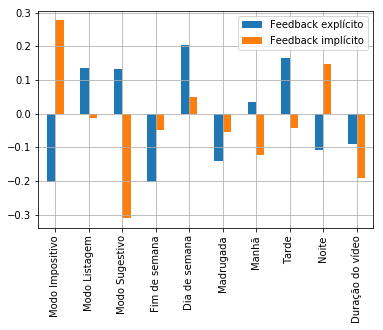

,Modo Impositivo,Modo Listagem,Modo Sugestivo,Fim de semana,Dia de semana,Madrugada,Manhã,Tarde,Noite,Duração do vídeo
Feedback explícito,-0.20,0.14,0.13,-0.20,0.20,-0.14,0.03,0.16,-0.11,-0.09
Feedback implícito,0.28,-0.01,-0.31,-0.05,0.05,-0.06,-0.12,-0.04,0.15,-0.19


In [18]:
# correlations considering the whole dataset
df_corr = get_correlation(df_ratings)

plt.clf()
df_corr.T.plot(kind='bar')
plt.grid(True)

plt.show()

df_corr.round(2)


************User ID = 7 name = Maria Carmo
[11 15 14 13 12 17 19 20 10 18 21  8  7  9]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


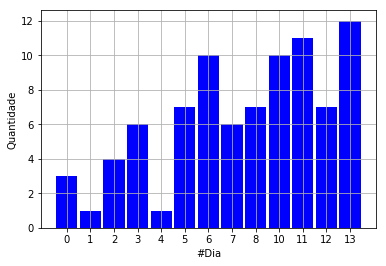


************User ID = 2 name = Cesar Castelao
[14 12 15 19 16  6  5 18  7]


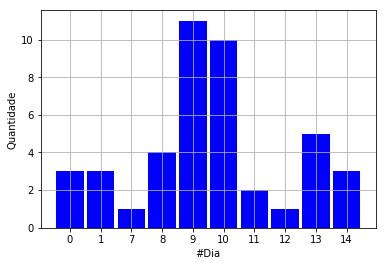


************User ID = 12 name = Daniel Pinto
[21 20 26 19 22 27 29 30]


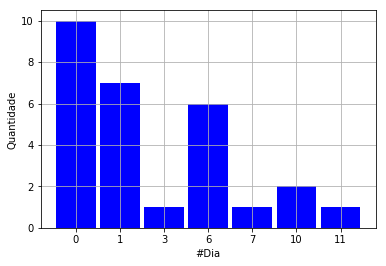


************User ID = 20 name = Otília
[30 31  3  6 29  5 12 11  9  2  8]


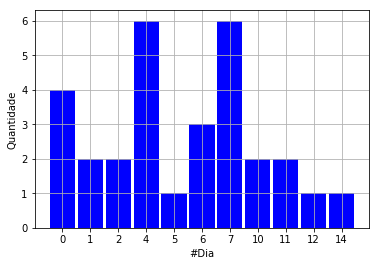


************User ID = 21 name = Alice
[29  5  1 30  4  2 12 11  9  3  6]


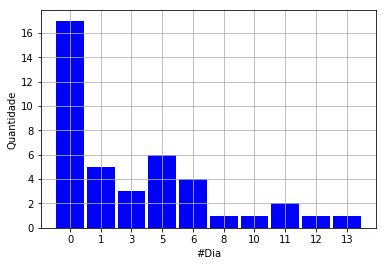


************User ID = 17 name = Teresa Amado
[12 14]


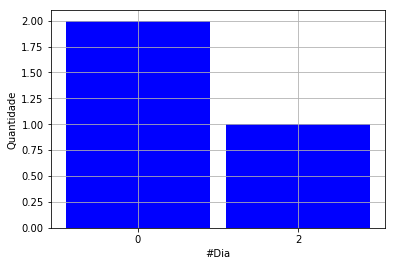


************User ID = 18 name = Lucete Martins
[ 9 14 17 10 11 12 13]


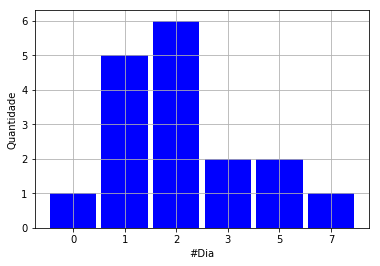


************User ID = 19 name = Lúcia Rodrigues
[14 12]


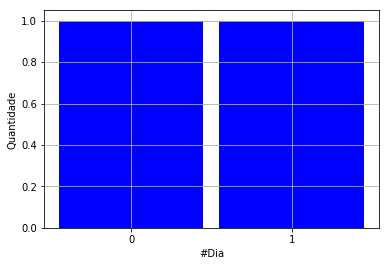


************User ID = 11 name = Mº Alice/António Lebre
[25 23 22 21 20 24 29 31]


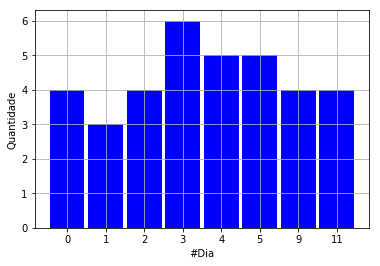


************User ID = 8 name = Rosa Ferreira (Vizinhos Rita)
[17 15 16 10 11 13  9 12]


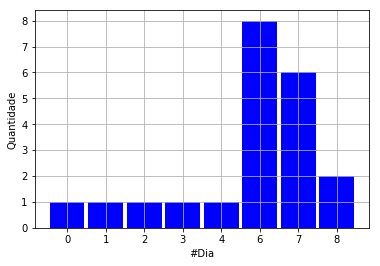


************User ID = 3 name = José Martins
[17 10  5 12 18  6]


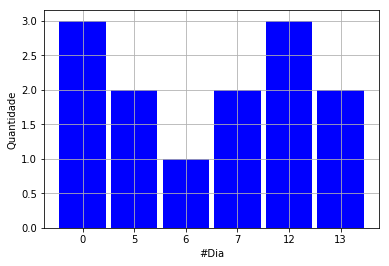


************User ID = 16 name = Adélia Gomes
[19 18 20 22 17 21 23 16  1 25 24 26 27 28  2]


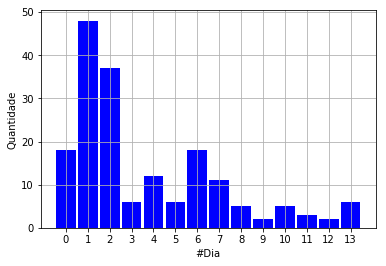


************User ID = 1 name = Helena Letra
[ 6 16 13 15  5 10]


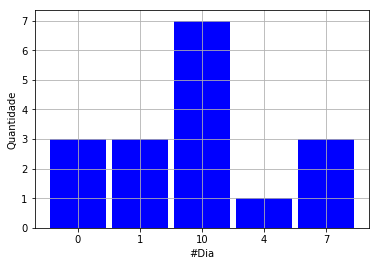


************User ID = 10 name = Teresa Rei
[20  1 31 30 29]


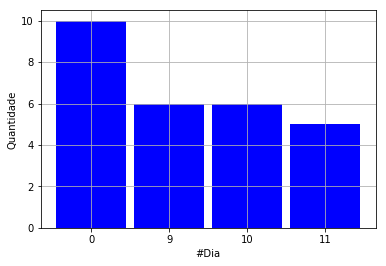


************User ID = 9 name = Helena Gala
[20 22 21 23 24 25 30 31]


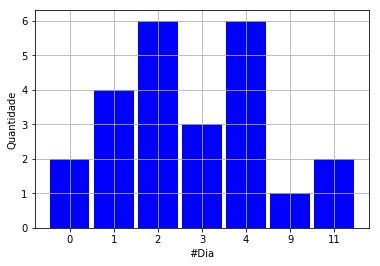


************User ID = 4 name = Ian Arbuckle
[4]


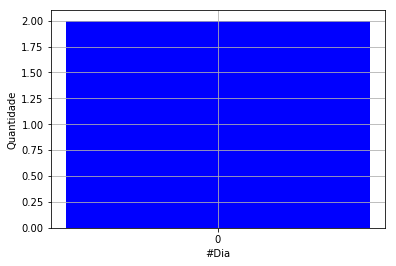


************User ID = 6 name = Hernani
[14  6 12]


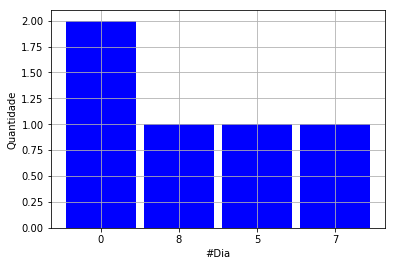


************User ID = 13 name = Manuela Marques
[24 16 18 20 23 21 22 27 28  1 17 26]


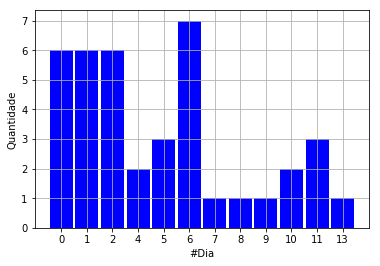


************User ID = 15 name = Manuel Gomes
[20  2 22 21 23 24]


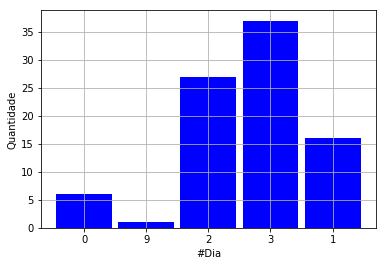


************User ID = 14 name = Rui Silva
[17 23 21 18 20 28 16 26 25  1  2 19 27 24]


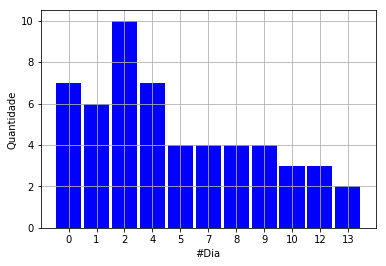


************User ID = 5 name = Francisco Silva
[18 13 16]


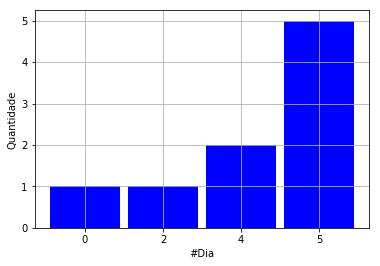

In [19]:
# listing days where users where active
users = df_ratings.user_id.unique()
for u in users:
    df = df_ratings[(df_ratings.user_id == u)]
    print("\n************User ID = {} name = {}".format(u, df.name.values[0]))
    print(df.date_creation.dt.day.unique())
    df['day_number'] = (df.date_creation - df.date_creation.min()).dt.days

    from collections import Counter

    d = Counter(df['day_number'])

    df = pd.DataFrame(list(d.items()), columns=['day_number', 'count'])
    ax1 = plt.subplot2grid((1,1), (0,0))

    ax1.bar(df.index, df['count'], color='b', width=0.9)
    ax1.set_ylabel('Quantidade')
    ax1.set_xlabel('#Dia')
    ax1.set_xticks(range(len(df.day_number)))
    ax1.set_xticklabels(df.day_number)
    fig.subplots_adjust(bottom=0.15)

    plt.grid(True)
    plt.show()


************User ID = 7 name = Maria Carmo
[11 15 14 13 12 17 19 20 10 18 21  8  7  9]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


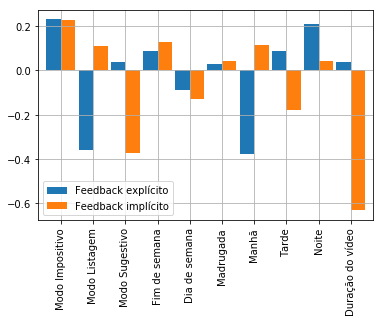


************User ID = 2 name = Cesar Castelao
[14 12 15 19 16  6  5 18  7]


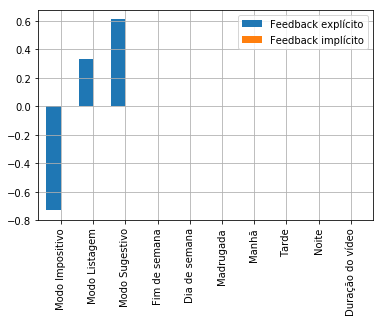


************User ID = 12 name = Daniel Pinto
[21 20 26 19 22 27 29 30]


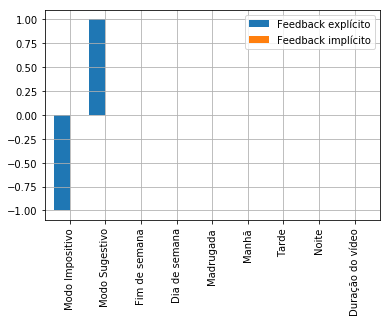


************User ID = 20 name = Otília
[30 31  3  6 29  5 12 11  9  2  8]


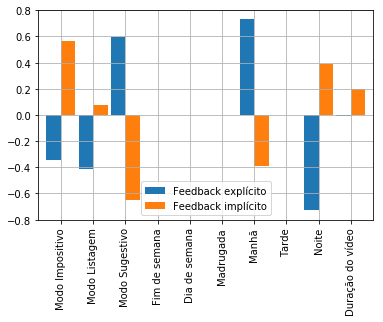


************User ID = 21 name = Alice
[29  5  1 30  4  2 12 11  9  3  6]


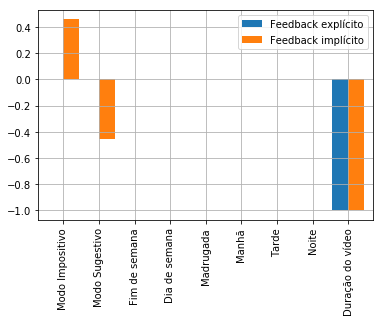


************User ID = 17 name = Teresa Amado
[12 14]


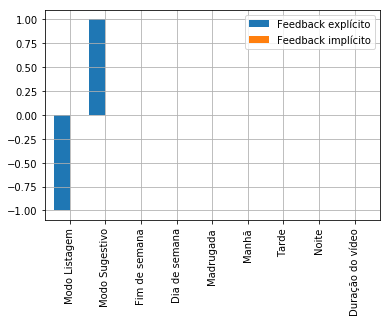


************User ID = 18 name = Lucete Martins
[ 9 14 17 10 11 12 13]


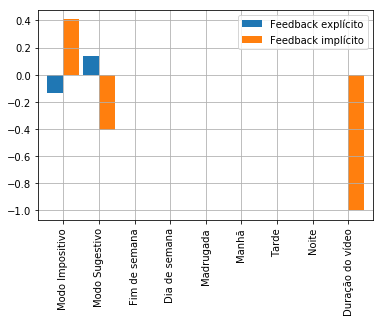


************User ID = 19 name = Lúcia Rodrigues
[14 12]


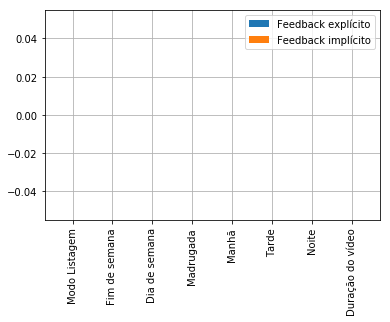


************User ID = 11 name = Mº Alice/António Lebre
[25 23 22 21 20 24 29 31]


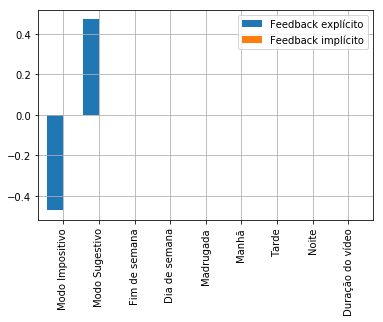


************User ID = 8 name = Rosa Ferreira (Vizinhos Rita)
[17 15 16 10 11 13  9 12]


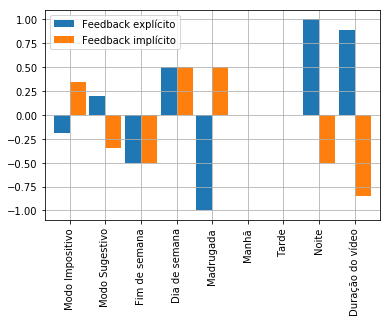


************User ID = 3 name = José Martins
[17 10  5 12 18  6]


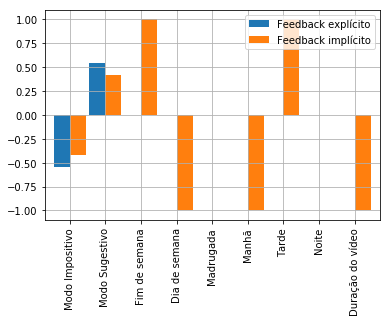


************User ID = 16 name = Adélia Gomes
[19 18 20 22 17 21 23 16  1 25 24 26 27 28  2]


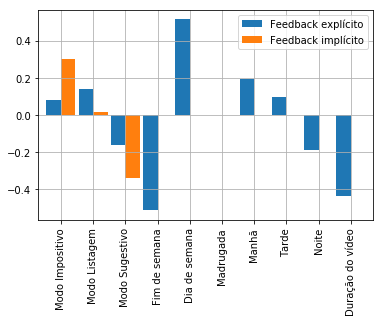


************User ID = 1 name = Helena Letra
[ 6 16 13 15  5 10]


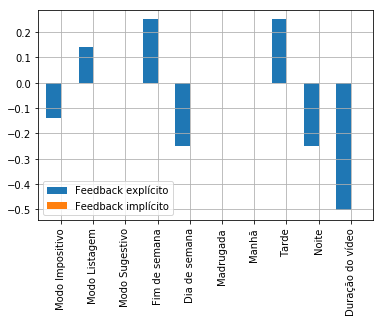


************User ID = 10 name = Teresa Rei
[20  1 31 30 29]


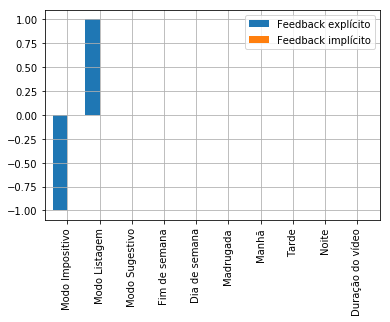


************User ID = 9 name = Helena Gala
[20 22 21 23 24 25 30 31]


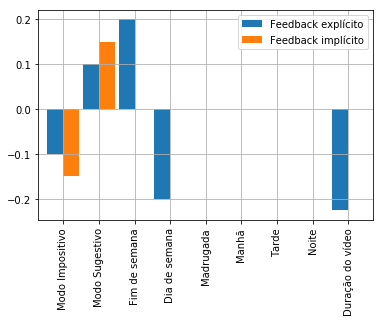


************User ID = 4 name = Ian Arbuckle
[4]


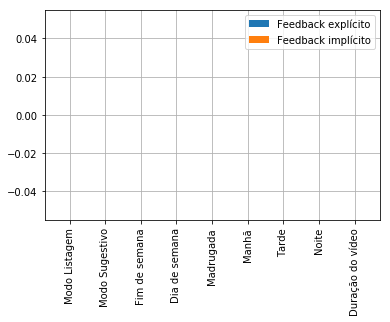


************User ID = 6 name = Hernani
[14  6 12]


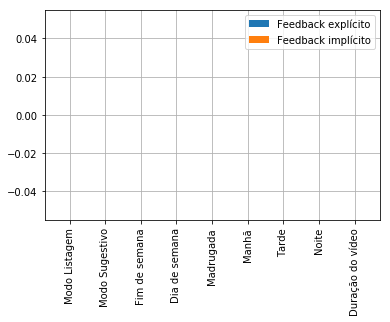


************User ID = 13 name = Manuela Marques
[24 16 18 20 23 21 22 27 28  1 17 26]


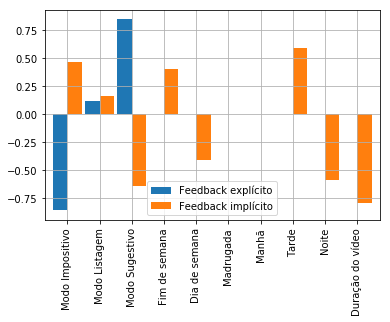


************User ID = 15 name = Manuel Gomes
[20  2 22 21 23 24]


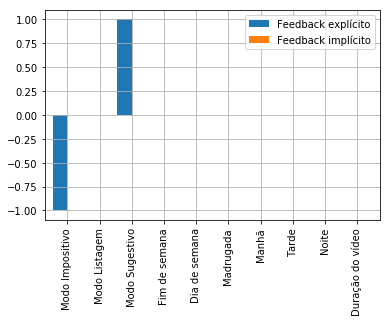


************User ID = 14 name = Rui Silva
[17 23 21 18 20 28 16 26 25  1  2 19 27 24]


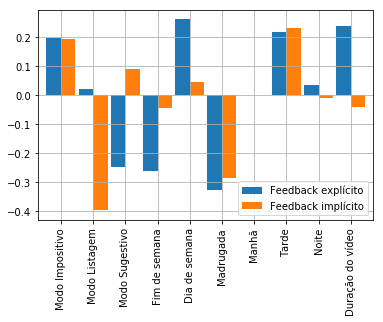


************User ID = 5 name = Francisco Silva
[18 13 16]


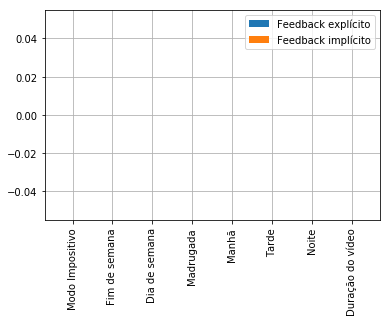

In [20]:
# listing days which users have used the system
users = df_ratings.user_id.unique()
for u in users:
    df = df_ratings[(df_ratings.user_id == u)]
    print("\n************User ID = {} name = {}".format(u, df.name.values[0]))
    print(df.date_creation.dt.day.unique())
    df['day_number'] = (df.date_creation - df.date_creation.min()).dt.days

    df = get_correlation(df)
    plt.clf()
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))

    df.T.plot(kind='bar', width=0.9, ax=ax1)
    fig.subplots_adjust(bottom=0.15)

    plt.grid(True)
    plt.show()


************User ID = 5 name = Otília count = 30 
[30 31  3  6 29  5 12 11  9  2  8]


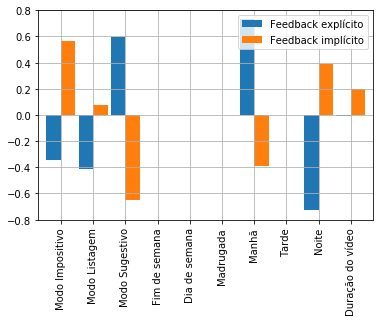

,Modo Impositivo,Modo Listagem,Modo Sugestivo,Fim de semana,Dia de semana,Madrugada,Manhã,Tarde,Noite,Duração do vídeo
Feedback explícito,-0.34,-0.41,0.60,NaN,NaN,NaN,0.73,NaN,-0.73,-0.01
Feedback implícito,0.56,0.08,-0.65,NaN,NaN,NaN,-0.39,NaN,0.39,0.20


In [21]:
# correlations of one user only
df = df_ratings[(df_ratings.user_id == 20)]
print("\n************User ID = {} name = {} count = {} ".format(u, df.name.values[0], df.shape[0]))
print(df.date_creation.dt.day.unique())
df = get_correlation(df)

plt.clf()
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

df.T.plot(kind='bar', width=0.9, ax=ax1)
fig.subplots_adjust(bottom=0.15)

plt.legend(loc='upper right')
plt.grid(True)
plt.show()

df.round(2)

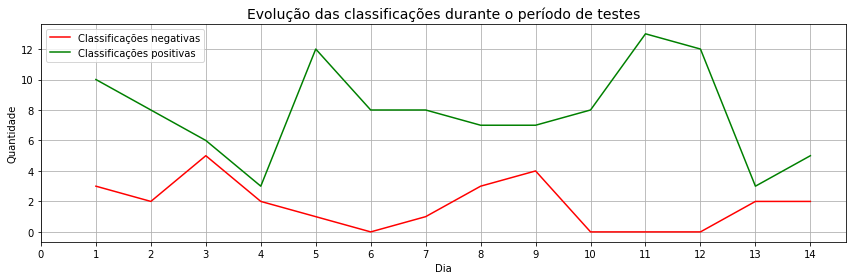

In [22]:
# positive/negative ratings evolution
df = df_ratings[['user_id', 'name', 'rating_explicit', 'rating_implicit', 'date_creation']]
for u in df_users.id.unique():
    date_min = df[(df.user_id == u)].date_creation.min()
    def f(row,u):
        if row.user_id == u:
            row.date_creation = row.date_creation - date_min
            
        return row
    
    df = df.apply(lambda row: f(row, u), axis=1)

df['delta'] = pd.to_datetime(df['date_creation']).dt.day

df.dropna(inplace=True)

df1 = df[df.rating_explicit == 1]
d = Counter(df1['delta'])
df1 = pd.DataFrame(list(d.items()), columns=['day', 'count'])


df2 = df[df.rating_explicit == -1]
df3 = df2
d = Counter(df2['delta'])
df2 = pd.DataFrame(list(d.items()), columns=['day', 'count'])
df2 = df2[df2.day <= 14]

for i in range(1,15,1):
        if not i in df1.day.values:
            df1.loc[df1.index.max() + 1] = [i, 0]
        if not i in df2.day.values:
            df2.loc[df2.index.max() + 1] = [i, 0]
df1.sort_values(by=['day'], inplace=True)
df2.sort_values(by=['day'], inplace=True)
            
plt.clf()
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((1,1), (0,0))

plt.title('Evolução das classificações durante o período de testes', fontsize=14)
ax1.plot(df2.day, df2['count'], color='r', label='Classificações negativas')
ax1.plot(df1.day, df1['count'], color='g', label='Classificações positivas')

ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Dia')
ax1.set_xticks(range(0,15))
ax1.set_xticklabels(range(0,15))
fig.subplots_adjust(bottom=0.15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

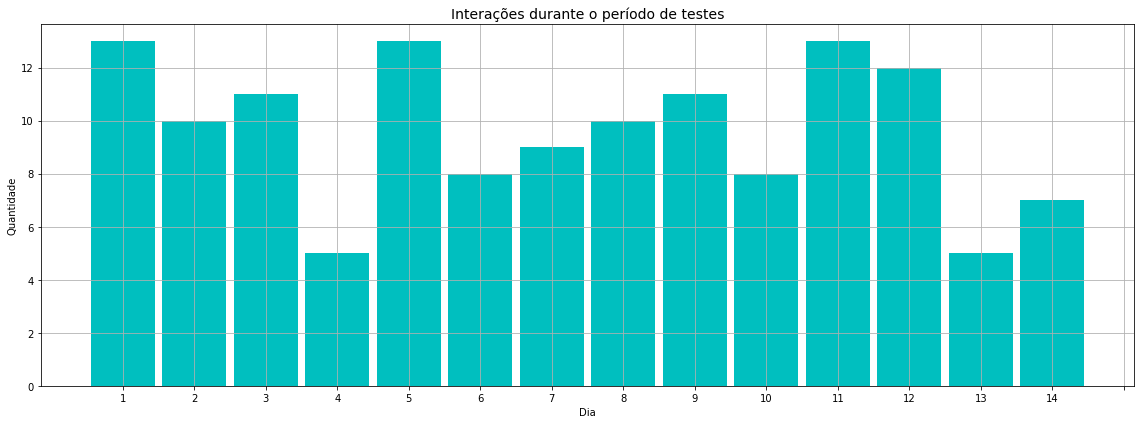

In [23]:
### positive/negative ratings evolution
df = df_ratings[['user_id', 'name', 'rating_explicit', 'rating_implicit', 'date_creation']]
for u in df_users.id.unique():
    date_min = df[(df.user_id == u)].date_creation.min()
    def f(row,u):
        if row.user_id == u:
            row.date_creation = row.date_creation - date_min
            
        return row
    
    df = df.apply(lambda row: f(row, u), axis=1)

df['delta'] = pd.to_datetime(df['date_creation']).dt.day

df.dropna(inplace=True)
df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

d = Counter(df['delta'])
df = pd.DataFrame(list(d.items()), columns=['day', 'count'])

df = df[df.day <= 14]

plt.clf()
fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot2grid((1,1), (0,0))

plt.title('Interações durante o período de testes', fontsize=14)
ax1.bar(df.index, df['count'], color='c', width=0.9)
ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Dia')

fig.subplots_adjust(bottom=0.15)
ax1.set_xticks(range(0,15))
ax1.set_xticklabels(range(1,15))

fig.subplots_adjust(bottom=0.15)
ax2.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
